## Practice is taken from this: https://darribas.org/gds_course/content/bB/diy_B.html

In [1]:
import sys
print(sys.executable)

import pyproj
pyproj.datadir.set_data_dir('/Users/yitong/opt/anaconda3/envs/forGeoPanda/share/proj')

/Users/yitong/opt/anaconda3/envs/forGeoPanda/bin/python


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import osmnx
import contextily as cx
import os

In [ ]:
url = ("https://docs.google.com/spreadsheets/d/"\
       "1EAx8_ksSCmoWW_SlhFyq2QrRn0FNNhcg1TtDFJzZRgc/"\
       "export?format=csv&gid=1")
print(url)

In [4]:
df = pd.read_csv(url, skiprows = [0],thousands= "," )
df = df.drop(df.tail(1).index)

df.tail()

Year      Month  Taliban  Civilians  Afghan forces  \
67  2009.0     August    445.0        206          190.0   
68  2009.0  September    614.0        197          133.0   
69  2009.0    October    462.0        107           86.0   
70  2009.0   November    410.0        120           69.0   
71  2009.0   December    287.0         87           65.0   

    Nato (detailed in spreadsheet)  Nato - official figures  
67                            64.0                     77.0  
68                            54.0                     70.0  
69                            76.0                     74.0  
70                            30.0                     32.0  
71                            33.0                     35.0

#### Minimum number of casualties and the month

In [5]:
print(df["Civilians"].min())

print(df[df.Civilians == df.Civilians.min()])

2
     Year  Month  Taliban  Civilians  Afghan forces  \
2  2004.0  March     19.0          2            NaN   

   Nato (detailed in spreadsheet)  Nato - official figures  
2                             2.0                      3.0  


#### How many NATO casualties were registered in August 2008?

In [6]:
nato = df[df["Year"] == 2008.0]
nato = df[df["Month"] == "August"]

print(nato)
print()
total_casualties = nato["Nato - official figures"].sum()
print(total_casualties)


      Year   Month  Taliban  Civilians  Afghan forces  \
7   2004.0  August     20.0         26           10.0   
19  2005.0  August     90.0          6           10.0   
31  2006.0  August    161.0        101           42.0   
43  2007.0  August    551.0         65           89.0   
55  2008.0  August    326.0         46           61.0   
67  2009.0  August    445.0        206          190.0   

    Nato (detailed in spreadsheet)  Nato - official figures  
7                              3.0                      4.0  
19                            13.0                     33.0  
31                            18.0                     29.0  
43                            31.0                     34.0  
55                            46.0                     46.0  
67                            64.0                     77.0  

223.0


#### What is the month with the most total number of casualties?

In [7]:
casualties = df.groupby("Month").sum()
total_casualties = casualties.drop(columns = ["Year"])
# print(total_casualties)

max_casualty = total_casualties.sum(axis=1).max()
compiled_casualties = total_casualties.sum(axis=1)

answer = compiled_casualties[compiled_casualties == max_casualty].index

print(answer.tolist())


['September']


#### Can you make a plot of the distribution of casualties over time?

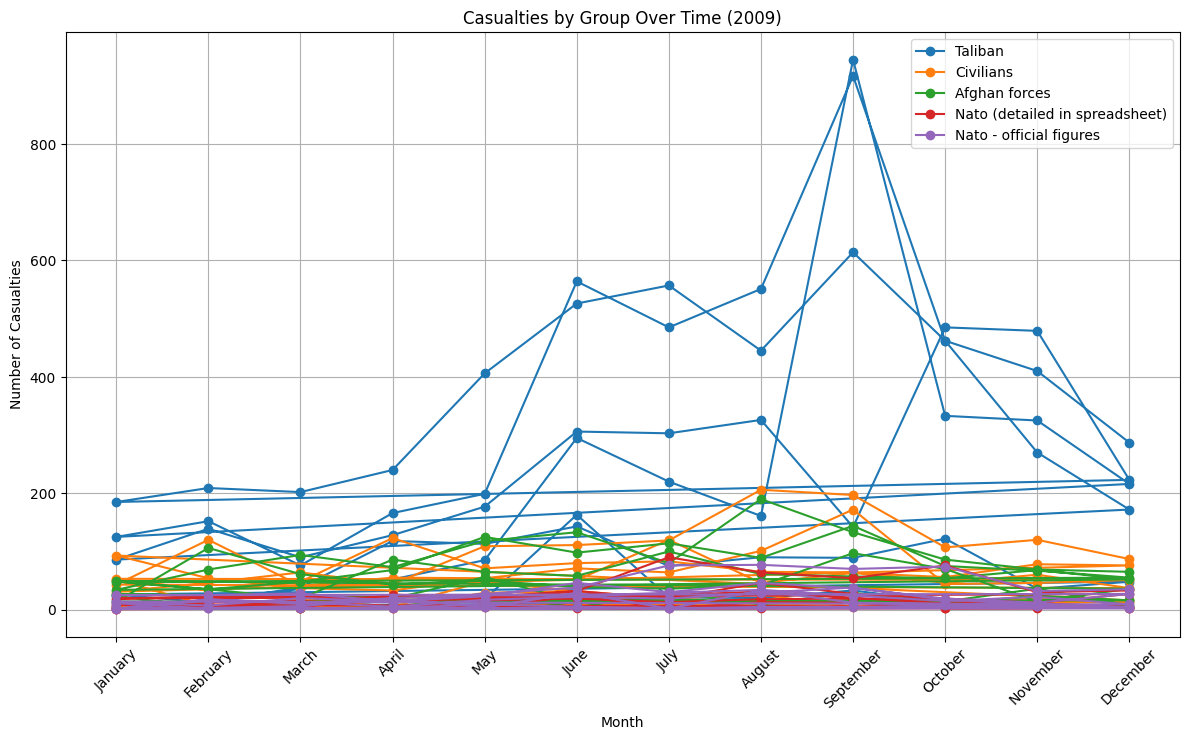

In [10]:
# Set up the plot
plt.figure(figsize=(12, 7))

# Plot each group
groups = ["Taliban", "Civilians", "Afghan forces", 
          "Nato (detailed in spreadsheet)", "Nato - official figures"]

for group in groups:
    plt.plot(df["Month"], df[group], marker='o', label=group)

# Customize the plot
plt.title("Casualties by Group Over Time (2009)")
plt.xlabel("Month")
plt.ylabel("Number of Casualties")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [10]:
cities = geopandas.read_file("../datasets/cities.gpkg")
# url = (
#     "https://github.com/geochicasosm/lascallesdelasmujeres"
#     "/raw/master/data/madrid/final_tile.geojson"
# )
# streets = geopandas.read_file(url)
streets = geopandas.read_file("../datasets/streets.gpkg")

In [ ]:
# get points of interest
# This is akin to searching "bars in madrid spain"
pois = osmnx.features_from_place(
    
    "Madrid, Spain", tags={"amenity": "bar"}
)

In [5]:
cities.head()

city_id  n_buildings                                           geometry
0   ci000         2348  POLYGON ((385390.071 4202949.446, 384488.697 4...
1   ci001         2741  POLYGON ((214893.033 4579137.558, 215258.185 4...
2   ci002         5472  POLYGON ((690674.281 4182188.538, 691047.526 4...
3   ci003        14608  POLYGON ((513378.282 4072327.639, 513408.853 4...
4   ci004         2324  POLYGON ((206989.081 4129478.031, 207275.702 4...

<AxesSubplot:>

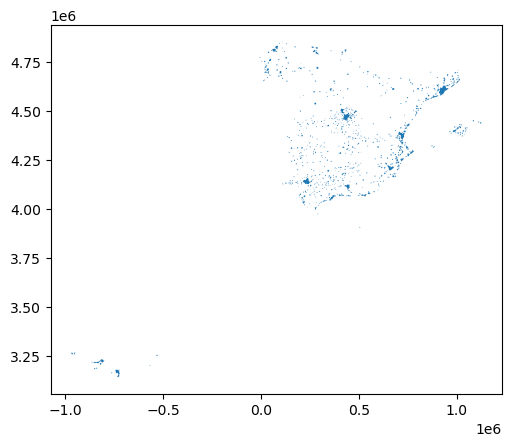

In [6]:
cities.plot()
# cities.loc[0, 'geometry']

<AxesSubplot:>

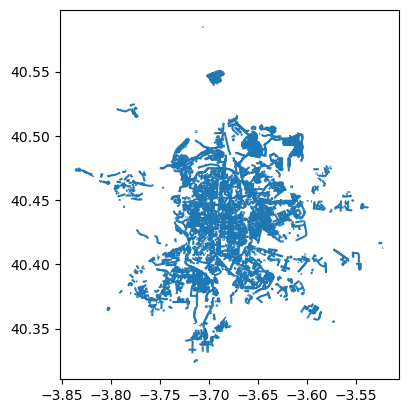

In [11]:
streets.plot()

<AxesSubplot:>

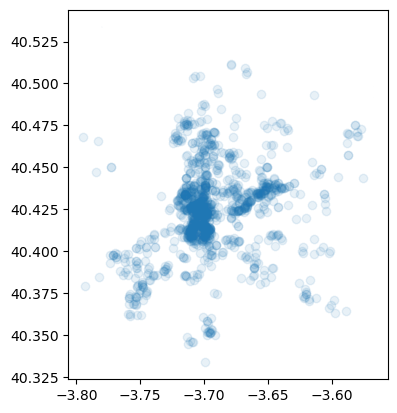

In [13]:
pois.plot(alpha = 0.1)

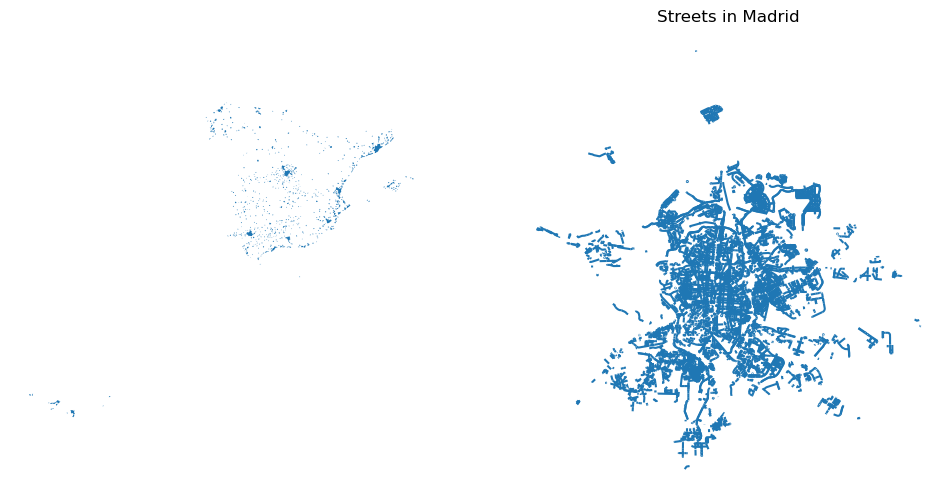

In [24]:
# removing axes to make map designs more flexible

# set up figure and axis
f, (ax1, ax2) = plt.subplots(1, 2 , figsize = (12, 6))
# plot layer of polygons on the axis
cities.plot(ax=ax1)
streets.plot(ax = ax2)
# remove axis frames
ax1.set_axis_off()
ax2.set_axis_off()
ax2.set_title("Streets in Madrid")
# display
plt.show()

### Transforming CRS

In [26]:
cities.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

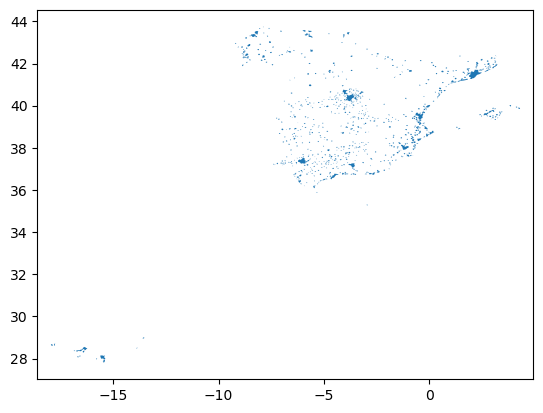

In [31]:
# reproject and plot polygons
cities.to_crs(epsg = 4326).plot()
# set equal axis
lims = plt.axis("equal")

### Composing Multi-layer maps

In [32]:
madrid = cities.loc[[12], :].to_crs(epsg=4326)
madrid

city_id  n_buildings                                           geometry
12   ci012       193714  POLYGON ((-3.90016 40.30421, -3.90019 40.30457...

<AxesSubplot:>

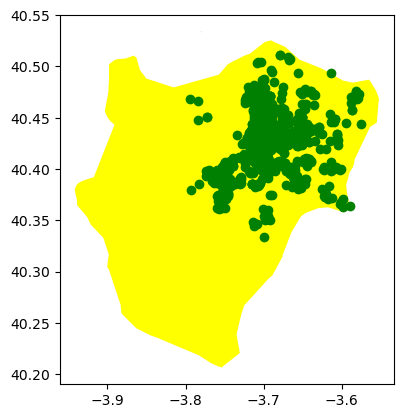

In [33]:
f, ax = plt.subplots(1)
# add a layer with polygon onto axis 'ax'
madrid.plot(ax=ax, color="yellow")
# add a layer with lines on top in axis 'ax'
pois.plot(ax=ax, color="green")

### Area Calculation

In [34]:
city_areas = cities.area
city_areas.head()

0    8.449666e+06
1    9.121270e+06
2    1.322653e+07
3    6.808121e+07
4    1.072284e+07
dtype: float64

### Length

In [ ]:
street_length = streets.to_crs(epsg = 25830).length
# this is presented in feet
street_length.head()

0    120.776840
1    120.902920
2    396.494357
3    152.442895
4    101.392357
dtype: float64

### Centroid Calculation

0    POINT (386147.759 4204605.994)
1    POINT (216296.159 4579397.331)
2    POINT (688901.588 4180201.774)
3    POINT (518262.028 4069898.674)
4    POINT (206940.936 4127361.966)
dtype: geometry


<AxesSubplot:>

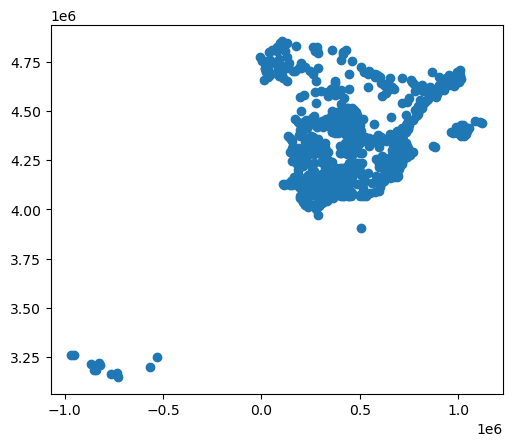

In [43]:
cents = cities.centroid
print(cents.head())
cents.plot()

### Buffers
Drawing an area around a particular geometery

In [44]:
# Use the bars in madrid table
pois_projected = pois.to_crs(cities.crs)
pois_projected.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
# call the 'buffer' method
buf = pois_projected.buffer(500)
buf.head()

element  id       
node     26808561     POLYGON ((440085.4 4475245.186, 440082.992 447...
         32639058     POLYGON ((440249.015 4474255.697, 440246.607 4...
         43274445     POLYGON ((441199.443 4482099.37, 441197.035 44...
         47216276     POLYGON ((440012.154 4473848.877, 440009.747 4...
         167301964    POLYGON ((441283.067 4473680.493, 441280.659 4...
dtype: geometry

<AxesSubplot:>

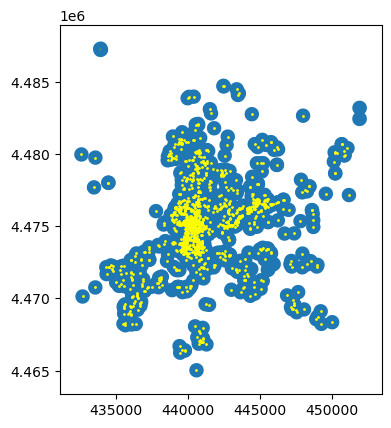

In [50]:
f, ax = plt.subplots()
# plot buffer
buf.plot(ax=ax, linewidth = 0)
pois_projected.plot(ax = ax, markersize = 1, color = "yellow")

### Add base layers from web sources
Note that we need to be explicit when adding the basemap to state the coordinate reference system (`crs`) our data is expressed in, `contextily` will not be able to pick it up otherwise.

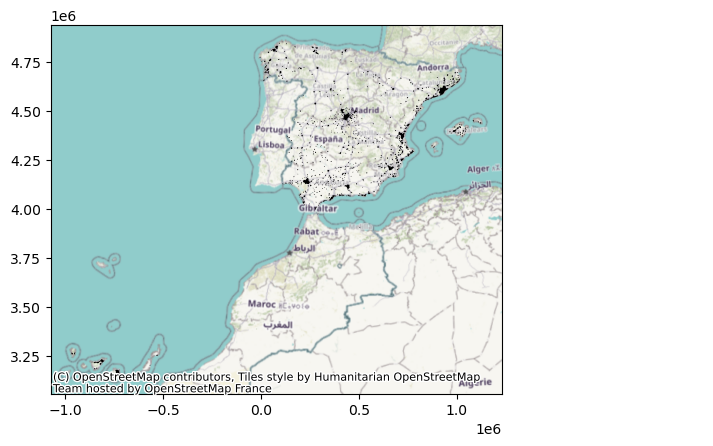

In [51]:
ax = cities.plot(color = "black")
cx.add_basemap(ax, crs = cities.crs)

Conversely, we can change our data's CRS into Pseudo-Mercator, the native reference system for most web tiles

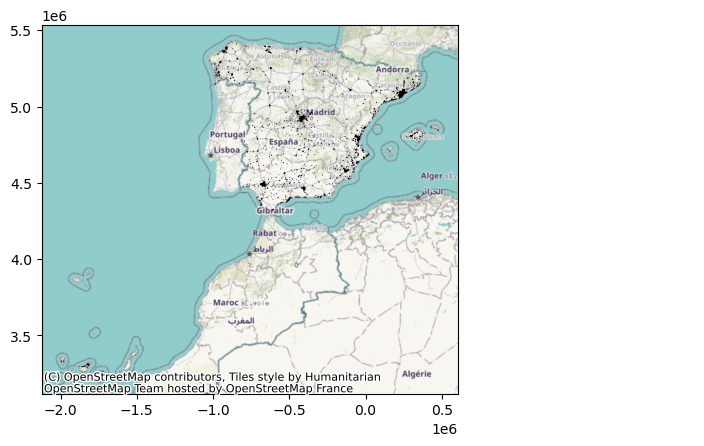

In [52]:
cities_wm = cities.to_crs(epsg = 3857)
ax = cities_wm.plot(color = "black")
cx.add_basemap(ax)

Web tiles can be integrated with other features of maps in a similar way as we have seen above. We can change the size and remove the axis

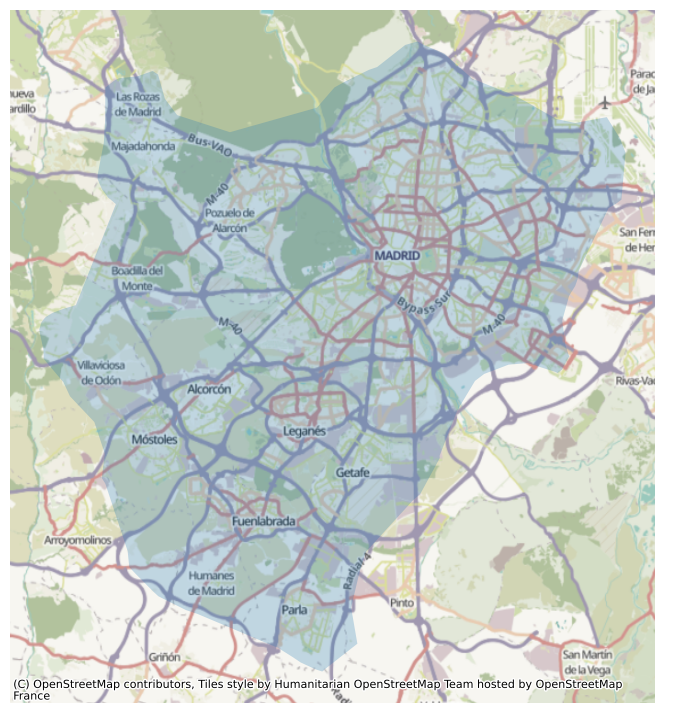

In [53]:
f, ax = plt.subplots(1, figsize = (9, 9))
madrid.plot(alpha = 0.25, ax = ax)
cx.add_basemap(ax, crs = madrid.crs)
ax.set_axis_off()

### Interactive maps

In [54]:
streets.explore()